In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import proxy_crm_modules as pCRM
import numpy as np

In [26]:
data_src = "D:/crmProject/dataSamples/pywaterflood-master/testing/data/"
prod = pd.read_csv(data_src + "production.csv", header= None)
inj = pd.read_csv(data_src + "injection.csv", header=None)
time = pd.read_csv(data_src + "time.csv", header= None)

train_size = int(0.75 * prod.shape[0])
test_size = int(0.25 * prod.shape[0])

In [7]:
prod_shut_in = pd.read_csv(data_src + "production.csv", header= None)

# Get the column as a NumPy array
column_val = prod_shut_in[1].to_numpy()

# Pad the array with zeros at the beginning
i = len(prod_shut_in[1])//2
padded_val = np.insert(column_val, i, np.zeros(20))
prod_shut_in[1] = padded_val[:len(prod_shut_in[1])]

In [8]:
inj_shut_in = pd.read_csv(data_src + "injection.csv", header= None)

# Get the column as a NumPy array
column_val = inj_shut_in[1].to_numpy()

# Pad the array with zeros at the beginning
i = len(inj_shut_in[1])//2
padded_val = np.insert(column_val, i, np.zeros(20))
inj_shut_in[1] = padded_val[:len(inj_shut_in[1])]

In [29]:
pressure = 1000-prod*0.1

In [44]:
#Create train-test dataset for non-shut-in.
inj_train = inj.values[:train_size]
prod_train = prod.values[:train_size]
time_train = time.values[:train_size]
press_train = pressure.values[:train_size]

inj_test = inj.values[test_size:]
prod_test = prod.values[test_size:]
time_test = time.values[test_size:]
press_test = pressure.values[test_size:]

# for shut-in.
inj_shut_in_train = inj_shut_in.values[:train_size]
prod_shut_in_train = prod_shut_in.values[:train_size]

inj_shut_in_test = inj_shut_in.values[test_size:]
prod_shut_in_test = prod_shut_in.values[test_size:]

In [31]:
proxy_crm = pCRM.proxyCRM()

In [39]:
proxy_crm.fit(prod_train, inj_train, press_train, time_train[:,0], num_cores=4)

In [41]:
q_hat = proxy_crm.predict(inj = inj_test, time = time_test[:,0])

In [54]:
shut_in_test = pCRM.proxyCRM()
shut_in_test.fit(prod_shut_in_train, inj_shut_in_train, press_train, time_train[:,0], num_cores=4)

In [55]:
q_hat_sh = shut_in_test.predict(inj = inj_shut_in_test, time = time_test[:,0])

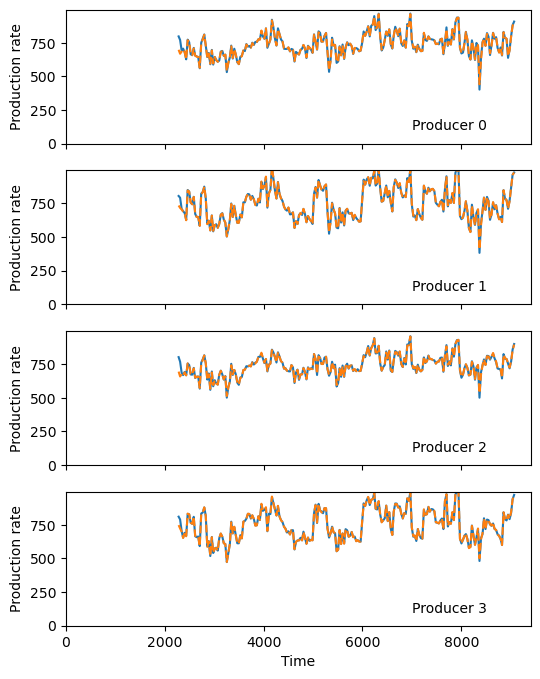

In [57]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time_test, prod_test[:,p], label=f"test P{p}")
    axes[i].plot(time_test, q_hat[:,p], ls="--", label=f"Prediction P{p}")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time");

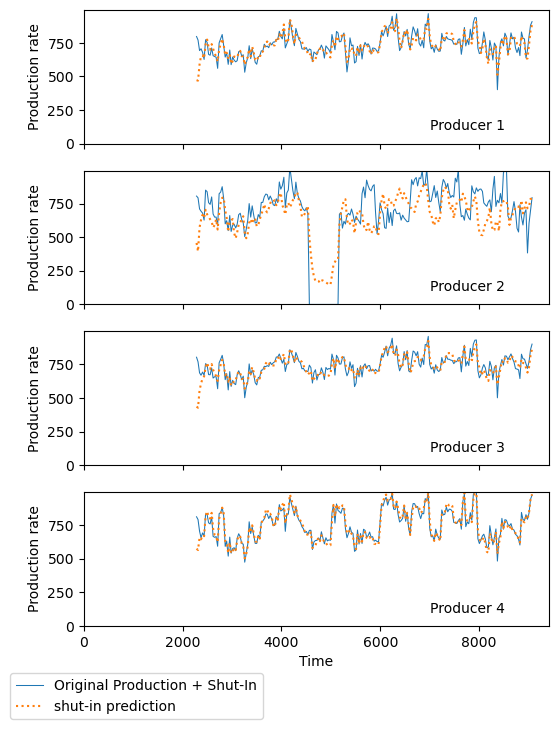

In [68]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)

for i, p in enumerate(prod):
    #axes[i].plot(time, prod[p], label="Production")
    #axes[i].plot(time, np.array(q_hat)[:, i], ls="--", label="Original Prediction")

    axes[i].plot(time_test, prod_shut_in_test[:,p], label="Original Production + Shut-In", linewidth=0.75)
    axes[i].plot(time_test, np.array(q_hat_sh)[:,p], ls=":", label="shut-in prediction")

    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(7000, 100))
axes[i].set(xlabel="Time")

legend = axes[i].legend(bbox_to_anchor =(0.4, -0.3))
legend = legend.set_draggable(True)

fig = plt.show()

In [69]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip,
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.33,0.33,0.17,0.17
1,0.33,0.17,0.33,0.17
2,0.25,0.25,0.25,0.25
3,0.17,0.33,0.17,0.33
4,0.17,0.17,0.33,0.33


In [70]:
shut_in_connectivity = pd.DataFrame(
    shut_in_test.lambda_ip,
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.41,0.036,0.22,0.2
1,0.049,1.0,0.043,0.016
2,0.3,0.0,0.3,0.27
3,0.17,0.25,0.17,0.37
4,0.24,0.12,0.42,0.36


In [15]:
"""an_array = np.array([[0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25]])
an_array = an_array.reshape(-1)
if len(an_array.shape) > 1:
	an_array = an_array.reshape(-1)
else:
	an_array = an_array
an_array = np.vstack(an_array)

print(an_array)"""

'an_array = np.array([[0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25]])\nan_array = an_array.reshape(-1)\nif len(an_array.shape) > 1:\n\tan_array = an_array.reshape(-1)\nelse:\n\tan_array = an_array\nan_array = np.vstack(an_array)\n\nprint(an_array)'